# Exploring Different Fitness / Selection Criterion

Goal 1: Implement surviving parents alongside reproducing population. Up until now, we have been selecting genes at random from the best 50% of the population. So the next generation was all children with an amalgam of genes from the parent generation. Now we will implement survivors. These are solutions in our population who not only have the opportunity to reproduce, but they will survive intact to the next generation. This will be a small subsample of the best of the best in out population maybe the top 10%. 

Goal 2: Test different ratios for the reproducing population and carryover population. Default is use the best 50% to reproduce and 10% to survive, what do other ratios look like? Which one works best/should we use for our model? How does this affect diversity vs accuracy?

Goal 3: Implement the "low-ranking chimp." In hierarchical chimpanzee society, it is mainly the "Alpha" males who mate with the females of the group. However, the lower ranking males do, on occasion reproduce too. I think it would be interesting to see if implementing a low probability chance that one or several of the lowest ranking individuals pass on their genes would affect the model. I predict that it will be some sort of 

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../ExplorationVsExploitation')  # Replace '/path/to/EVO_BASE' with the actual path to the module
from EVO import LogisticRegression, EvolutionOptimizer
from fitness import FitnessOptimizer
import torch
import numpy as np
import time
import random
import matplotlib.pyplot as plt

In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

In [4]:
def accuracy(model, X, y):
    device = model.w.device if model.w is not None else torch.device("cpu")
    X, y = X.to(device), y.to(device)
    y_pred = model.predict(X)
    return (y_pred == y).float().mean().item()


Training on cuda
Epoch 1
    Accuracy: 0.7899999618530273
    Loss: -2.497194528579712
Epoch 1
    Accuracy: 0.8399999737739563
    Loss: -2.487136125564575
Epoch 1
    Accuracy: 0.8499999642372131
    Loss: -2.5333261489868164
Epoch 1
    Accuracy: 0.85999995470047
    Loss: -2.617175579071045
Epoch 1
    Accuracy: 0.8899999856948853
    Loss: -2.653749942779541
Epoch 1
    Accuracy: 0.8899999856948853
    Loss: -2.6630074977874756
Epoch 1
    Accuracy: 0.9199999570846558
    Loss: -2.663079023361206
Epoch 1
    Accuracy: 0.9099999666213989
    Loss: -2.6648945808410645
Epoch 1
    Accuracy: 0.9599999785423279
    Loss: -2.674238681793213
Epoch 1
    Accuracy: 0.9300000071525574
    Loss: -2.74611759185791
Epoch 1
    Accuracy: 0.9799999594688416
    Loss: -2.7876343727111816
Epoch 1
    Accuracy: 0.9799999594688416
    Loss: -2.785341501235962
Epoch 1
    Accuracy: 0.9899999499320984
    Loss: -2.7616946697235107
Epoch 1
    Accuracy: 1.0
    Loss: -2.7707881927490234
Time taken:  91

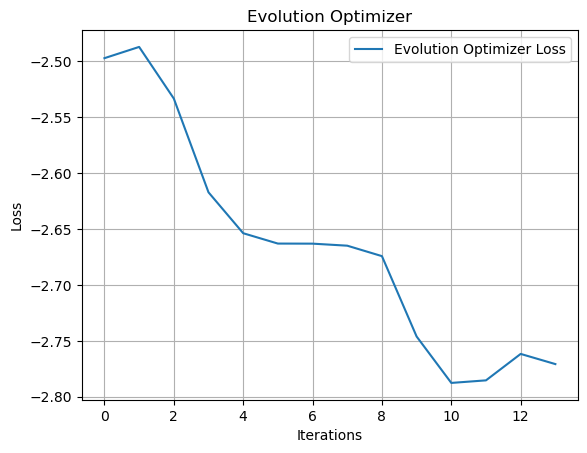

In [ ]:
X, y = classification_data(p_dims=200, noise=0.2, n_points=100)
LR = LogisticRegression()
opt = FitnessOptimizer(LR)
LR.set_optimizer(opt)
opt.set_mutation_rate(0.5)
opt.set_population_size(100)
opt.set_fitness_ratio(0.25)

print(f'Training on {opt.device}')

device = opt.device
X, y = X.to(device), y.to(device)

loss = []
epoch = 1
start = time.time()
while accuracy(LR, X, y) < 1:
    opt.step(X, y)
    loss.append(LR.loss(X, y).item())
    print(f"Epoch {epoch}\n    Accuracy: {accuracy(LR, X, y)}\n    Loss: {loss[-1]}")
    epoch += 1


print("Time taken: ", time.time() - start)
plt.plot(loss, label="Evolution Optimizer Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Evolution Optimizer")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
thresh_range = np.arange(0.1, 0.5, 0.1)
loss_dict = {}

for thresh in range(len(thresh_range)):
    print(f"Running for thresh = {thresh}")
    
    # Generate new data for fairness (or keep it fixed if you prefer)
    X, y = classification_data(p_dims=200, noise=0.8, n_points=100)
    
    # Set up model and optimizer
    LR = LogisticRegression()
    opt = FitnessOptimizer(LR)
    LR.set_optimizer(opt)
    opt.set_population_size(100)
    opt.set_diversity_coeff(0)
    opt.set_fitness_ratio(thresh_range[thresh])
    
    # Loss tracking
    loss = []
    start = time.time()
    ep = 1
    
    # Optimization loop
    while accuracy(LR, X, y) < 1:
        print(f"Epoch {ep}")
        opt.step(X, y)
        loss.append(LR.loss(X, y).item())
    
    print(f"Finished in {len(loss)} iterations, Time: {round(time.time() - start, 2)}s")
    loss_dict[thresh_range[thresh]] = loss

# Plotting
plt.figure(figsize=(12, 8))
for k, loss in loss_dict.items():
    plt.plot(loss, label=f"Best {k*100:.0f}%")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Evolution Optimizer Loss vs Survival Ratio")
plt.legend(title="Thresholds")
plt.grid(True)
plt.show()


Running for thresh = 0
Epoch 1


KeyboardInterrupt: 